# import all the dependencies

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.transforms import ToTensor
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

 # Preparing the dataset

In [4]:
# apply transformation
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))])

# download the data
training_data = torchvision.datasets.EMNIST(root='contents/',download=True, transform=transform, train=True,split='balanced')
test_data = torchvision.datasets.EMNIST(root='contents/',download=True, transform=transform, train=False,split='balanced')

# build the data loader
train_loader = torch.utils.data.DataLoader(dataset = training_data,
                                           batch_size = 128,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                           batch_size = 128,
                                           shuffle = True)

In [5]:
training_data.data.shape

torch.Size([112800, 28, 28])

In [6]:
len(training_data.classes)

47

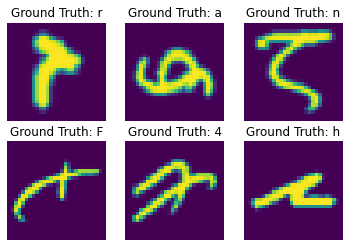

In [7]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(training_data.data[i])
  plt.title('Ground Truth: {}'.format(training_data.classes[training_data.targets[i]]))
  plt.axis('off')

# Building the model

In [8]:
# considered model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size= 5,stride = 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc = nn.Linear(64*20*20, 47)
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

# initiating the model
model = CNNModel()

# Compiling the model

In [9]:
# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  

In [10]:
device

device(type='cuda')

# Training, testing and evaluation procedure 

In [11]:
# fetch model to the working device
model.to(device)

# training loss
train_loss = []
test_losses =[]
def train(e):
    #Load in the data 
    for i, (images, labels) in enumerate(train_loader):  
      # load data on to device
      images = images.to(device)
      labels = labels.to(device)
          
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
          
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_loss.append(loss.item())
    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(e+1, 10, loss.item()))

In [12]:
def test():
  test_loss = 0
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          test_loss += F.nll_loss(outputs, labels, size_average=False).item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      print('Test Accuracy: {:4f} %, Test loss: {:4f}'.format((100 * correct / total),test_loss))

In [13]:
for i in range(10):
  train(i)
  test()

Epoch [1/10], Train Loss: 0.9228
Test Accuracy: 54.244681 %, Test loss: 1.690898
Epoch [2/10], Train Loss: 0.8392
Test Accuracy: 60.984043 %, Test loss: 1.376819
Epoch [3/10], Train Loss: 1.1005
Test Accuracy: 63.218085 %, Test loss: 1.286025
Epoch [4/10], Train Loss: 0.8227
Test Accuracy: 65.095745 %, Test loss: 1.213706
Epoch [5/10], Train Loss: 1.0662
Test Accuracy: 67.505319 %, Test loss: 1.126089
Epoch [6/10], Train Loss: 0.9846
Test Accuracy: 70.244681 %, Test loss: 1.012188
Epoch [7/10], Train Loss: 0.6088
Test Accuracy: 72.191489 %, Test loss: 0.940170
Epoch [8/10], Train Loss: 0.9456
Test Accuracy: 75.638298 %, Test loss: 0.842691
Epoch [9/10], Train Loss: 0.6872
Test Accuracy: 76.170213 %, Test loss: 0.816612
Epoch [10/10], Train Loss: 0.7250
Test Accuracy: 77.595745 %, Test loss: 0.742287


**This results in a testing accuracy of about 78%.**

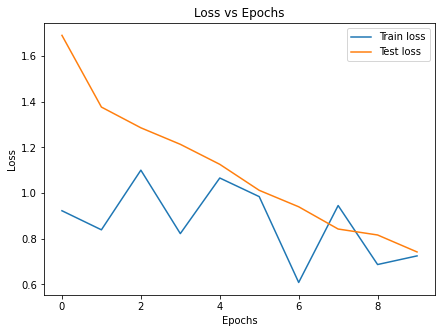

In [14]:
plt.figure(figsize=(7,5))
plt.plot(train_loss,label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()